# UJIAN PRAKTEK COMPUTER VISION


*   MOH DZAKY IRHAB
*   STARLA



# 1. Importing packages

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Sequential

In [ ]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
!kaggle competitions download -c ofa-ai-mastery-computer-vision

 99% 273M/276M [00:01<00:00, 180MB/s]
100% 276M/276M [00:01<00:00, 149MB/s]


In [ ]:
import zipfile
from zipfile import ZipFile
file_name = "/content/ofa-ai-mastery-computer-vision.zip"
extract_folder_path = '/content/uprak'

# buat folder extract jika belum ada
if not os.path.exists(extract_folder_path):
    os.makedirs(extract_folder_path)

# ekstraksi file zip ke folder extract
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)
    print('Done')

Done


In [ ]:
path = '/content/uprak'

# 2. Visualising data

In [ ]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path+'/train'):
    nums.append(len(os.listdir(path+'/train/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,cat,700
1,deer,600
2,horse,600
3,dog,900


<Axes: xlabel='Name of class', ylabel='Number of samples'>

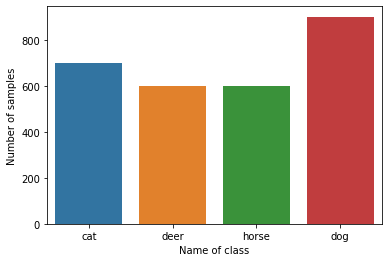

In [ ]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

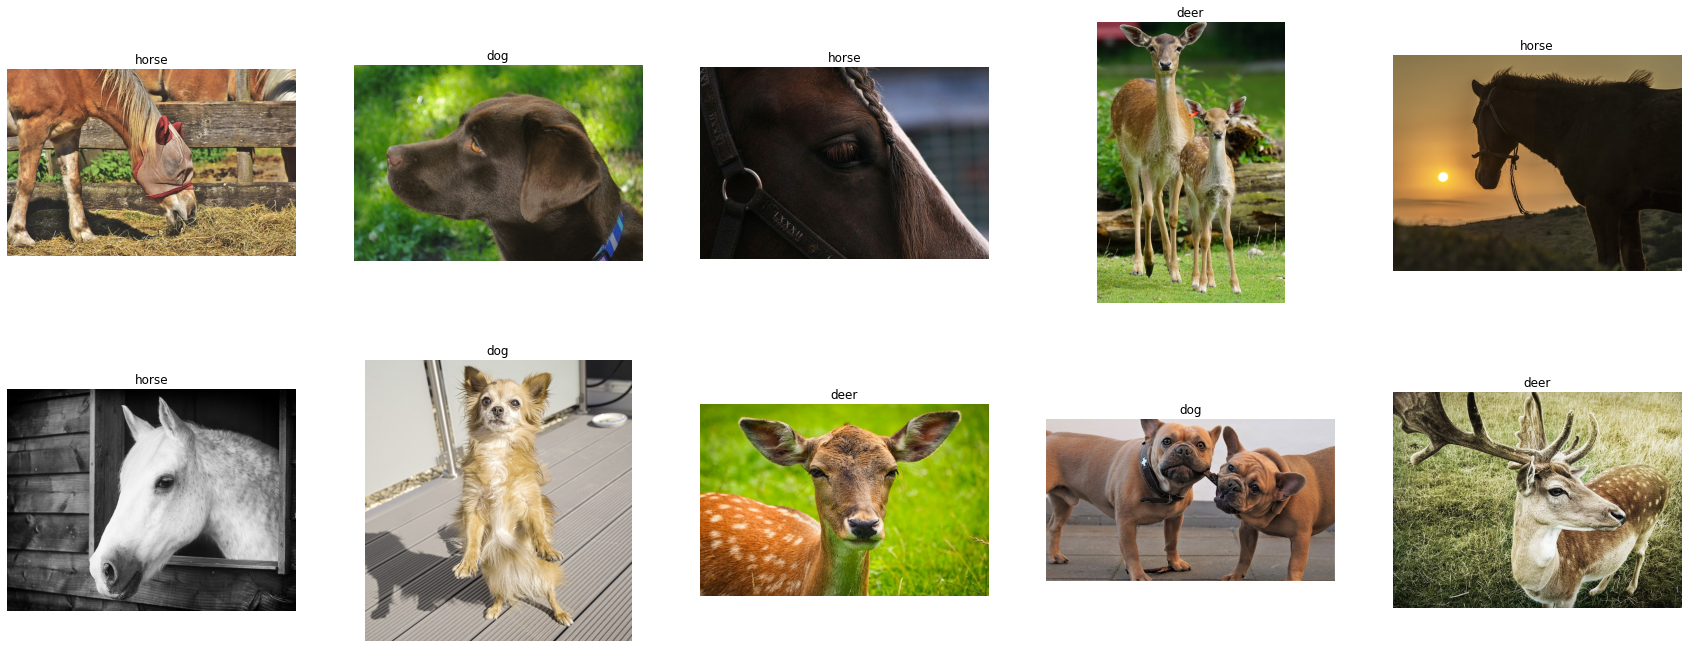

In [ ]:
classes = os.listdir(path+'/train')

plt.figure(figsize=(30 , 30))
for x in range(10):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0,600)                  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

# 3. Preparing the data

In [ ]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range = 0.2, # menambahkan parameter shear_range
                                                                zoom_range = 0.2, # menambahkan parameter zoom_range
                                                                brightness_range = (0.8, 1.2), # menambahkan parameter brightness_range
                                                                horizontal_flip=True, validation_split=0.3) # mengubah split menjadi 30%

Parameter yang saya tambahkan yaitu shear range, zoom range dan brightness range. dari yang saya pelajari dari documentation :   

*   shear range merupakan parameter yang digunakan untuk mengapply seberapa jumlah distorsi untuk image.
*   zoom range merupakan parameter yang digunakan untuk mengatur tingkat pembesaran yang diterapkan pada image.
*   dan untuk brightness range adalah parameter yang digunakan untuk mengatur nilai rentang kecerahan dalam image.

dan untuk nilai valdation split saya naikkan menjadi 0.3 / 30%




In [ ]:
train_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='training',
        target_size=(400 , 400),
        batch_size=40)

val_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='validation',
        target_size=(400 , 400),
        batch_size=40 )

Found 1960 images belonging to 4 classes.
Found 840 images belonging to 4 classes.


target size diubah menjadi 400,400 dan batch size diubah menjadi 40

# 4. Building the model

In [ ]:
#menggunakan inception_v3.InceptionV3

inception = tf.keras.applications.inception_v3.InceptionV3(input_shape=(400 , 400, 3),
                                           include_top=False,
                                           weights='imagenet')
for layer in inception.layers:
    layer.trainable = False

model = Sequential()
model.add(inception)
model.add(GlobalMaxPooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))  # nilai dropout rate sebesar 0.2
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))  # nilai dropout rate sebesar 0.2
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))  # nilai dropout rate sebesar 0.2
model.add(Dense(4, activation="softmax" , name="classification"))

pada model diatas saya menggunakan CNN dengan base model InceptionV3. pada model ini juga saya menerapkan Transfer learning yang dimana tujuan saya untuk melakukan freeze. semua layer dalam model inception menjadi non-trainable atau tidak dapat diubah saat proses pelatihan (training) pada model.

disini saya menggunakan globalmaxpooling2d,dense yang saya tambahkan lebih banyak dan juga penggunaan dropout untuk menghindari adanya overfitting pada pelatihan

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,momentum=0.9),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 11, 11, 2048)      21802784  
                                                                 
 global_max_pooling2d_3 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                      

# 5. Training and evaluating

In [ ]:
history = model.fit(train_ds , validation_data = val_ds , epochs = 15) #ditambah epoch 15 kali

Epoch 1/15
49/49 [==============================] - 132s 3s/step - loss: 1.0326 - accuracy: 0.6490 - val_loss: 0.1578 - val_accuracy: 0.9714
Epoch 2/15
49/49 [==============================] - 124s 3s/step - loss: 0.3126 - accuracy: 0.9036 - val_loss: 0.1239 - val_accuracy: 0.9619
Epoch 3/15
49/49 [==============================] - 125s 3s/step - loss: 0.1829 - accuracy: 0.9459 - val_loss: 0.1043 - val_accuracy: 0.9726
Epoch 4/15
49/49 [==============================] - 124s 3s/step - loss: 0.1544 - accuracy: 0.9536 - val_loss: 0.0967 - val_accuracy: 0.9679
Epoch 5/15
49/49 [==============================] - 128s 3s/step - loss: 0.1300 - accuracy: 0.9607 - val_loss: 0.0714 - val_accuracy: 0.9774
Epoch 6/15
49/49 [==============================] - 124s 3s/step - loss: 0.1367 - accuracy: 0.9597 - val_loss: 0.0669 - val_accuracy: 0.9798
Epoch 7/15
49/49 [==============================] - 128s 3s/step - loss: 0.1421 - accuracy: 0.9592 - val_loss: 0.0944 - val_accuracy: 0.9714
Epoch 8/15
49

21/21 [==============================] - 38s 2s/step - loss: 0.0764 - accuracy: 0.9798


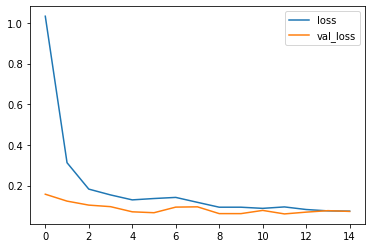

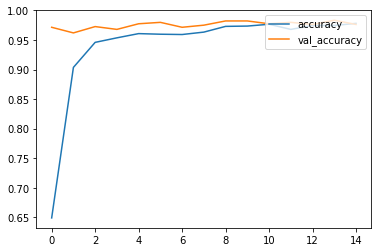

In [ ]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

# 6. Preparing for submission

In [ ]:
sub_csv ='/content/uprak/Sample_submission.csv'
path_test = '/content/uprak/test/test'

In [ ]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [ ]:
# each image will be treated individually and saved in a list which is then merged with the id of it's correspondence

from tensorflow.keras.preprocessing.image import load_img


# making a list for our predictions
labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(400, 400))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,400,400,3)
    label = model.predict(img)
    label_id = label[0].tolist()

    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 0s 32ms/step


In [ ]:
# we will replace the previous empty columns with the new predictions

df_sub['Label'] = labels
df_sub.head(10)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,2


In [ ]:
# saving file
df_sub.to_csv('submission_file.csv',index=False)